# Melbourne Housing Market

Coded by Emile Badran in May/2018

This notebook uses a Kaggle data set to predict a house values. We want to be able to understand what creates value in a house, as though we were a real estate developer.

Link to the data set=
https=//www.kaggle.com/anthonypino/melbourne-housing-market

In [21]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')

import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

import multiprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error

from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn import ensemble

### Importing and inspecting the data set

In [4]:
# Read the data file
raw_data = pd.read_csv('Melbourne_housing_FULL.csv')

# Convert "Date" column to datetime
raw_data.Date = pd.to_datetime(raw_data.Date)

# Create a column with year data
raw_data['Year'] = raw_data['Date'].dt.year

# Drop unnecessary column
raw_data.drop(['Propertycount','Regionname','Lattitude','Longtitude',
               'CouncilArea','Address','Date','Postcode'],1,inplace=True)

# Rearrange columns
raw_data = raw_data[['Suburb', 'Type','Method', 'SellerG','YearBuilt','Year','Rooms','Distance','Bedroom2',
             'Bathroom', 'Car','Landsize', 'BuildingArea','Price']]

raw_data.head()

,Suburb,Type,Method,SellerG,YearBuilt,Year,Rooms,Distance,Bedroom2,Bathroom,Car,Landsize,BuildingArea,Price
0,Abbotsford,h,SS,Jellis,NaN,2016,2,2.5,2.0,1.0,1.0,126.0,NaN,NaN
1,Abbotsford,h,S,Biggin,NaN,2016,2,2.5,2.0,1.0,1.0,202.0,NaN,1480000.0
2,Abbotsford,h,S,Biggin,1900.0,2016,2,2.5,2.0,1.0,0.0,156.0,79.0,1035000.0
3,Abbotsford,u,VB,Rounds,NaN,2016,3,2.5,3.0,2.0,1.0,0.0,NaN,NaN
4,Abbotsford,h,SP,Biggin,1900.0,2017,3,2.5,3.0,2.0,0.0,134.0,150.0,1465000.0


#### Column metadata
- Suburb= Suburb
- Rooms= Number of rooms
- Price= Price in dollars
- Method= S - property sold; SP - property sold prior; PI - property passed in; PN - sold prior not disclosed; SN - sold not disclosed; NB - no bid; VB - vendor bid; W - withdrawn prior to auction; SA - sold after auction; SS - sold after auction price not disclosed. N/A - price or highest bid not available.
- Type= br - bedroom(s); h - house,cottage,villa, semi,terrace; u - unit, duplex; t - townhouse; dev site - development site; o res - other residential.
- SellerG= Real Estate Agent
- Year= Year sold
- Distance= Distance from CBD
- Bedroom2 = Scraped # of Bedrooms (from different source)
- Bathroom= Number of Bathrooms
- Car= Number of carspots
- Landsize= Land Size
- BuildingArea= Building Size
- YearBuilt= Year the house was built

### Dropping and imputing null cells

The data set has many missing values. We'll drop the rows without property prices (22% of the data set).

We'll also **iterate over each Suburb area**, and impute the average values. This should result in better average values than imputing the entire column mean.

Data will also be scaled for better model performance.

In [5]:
# Inspect the ratio of missing values
print('Ratio of rows with null values=',
      len(raw_data[raw_data.isnull().any(axis=1)])/len(raw_data))
print('Ratio of rows without property prices=',
      raw_data.Price.isnull().sum()/len(raw_data))

Ratio of rows with null values= 0.7448145279283932
Ratio of rows without property prices= 0.2183205668875692


In [6]:
# Drop rows without property price and reset dataframe index
data = raw_data.dropna(subset=['Price'])
data.reset_index(drop=True, inplace=True)

# Create a list of unique suburb names
suburbs = data.Suburb.unique()

# Create a dataframe to store imputed data
imputed_data = pd.DataFrame()

# Iterate over suburbs and fill missing values with column mean
for i in suburbs:
    temp_df = data.iloc[:,4:-1].loc[data['Suburb'] == i] # Create temp dataframe with numeric values
    temp_df = temp_df.fillna(temp_df.mean()) # Fill null values with column mean
    imputed_data = imputed_data.append(temp_df) # Append values to imputed_data
    
# Fill any outstanding nulls with column means
imputed_data = imputed_data.fillna(imputed_data.mean())

# Update data columns with imputed data
data[['YearBuilt', 'Year', 'Rooms', 'Distance', 'Bedroom2', 'Bathroom', 'Car',
       'Landsize', 'BuildingArea']] = imputed_data

data.head(3)

,Suburb,Type,Method,SellerG,YearBuilt,Year,Rooms,Distance,Bedroom2,Bathroom,Car,Landsize,BuildingArea,Price
0,Abbotsford,h,S,Biggin,1943.215686,2016,2,2.5,2.0,1.0,1.0,202.0,101.191489,1480000.0
1,Abbotsford,h,S,Biggin,1900.000000,2016,2,2.5,2.0,1.0,0.0,156.0,79.000000,1035000.0
2,Abbotsford,h,SP,Biggin,1900.000000,2017,3,2.5,3.0,2.0,0.0,134.0,150.000000,1465000.0


### Inspecting variance and dropping outliers
To improve model performance, "Landsize" and "BuildingArea" outliers will be removed. Only 2% of the observations will be deleted.

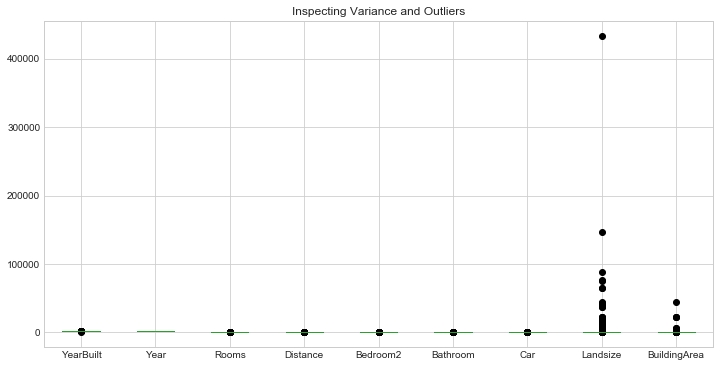

In [7]:
# Plot a boxplot to inspect variance
data.iloc[:,4:-1].boxplot(figsize=(12,6), sym='ko', grid=True)
plt.title('Inspecting Variance and Outliers')
plt.show()

In [8]:
# Store the number of rows before dropping
rows_before = data.shape[0]

# Delete Landsize and BuildingArea outliers
data = data[data.Landsize < data.Landsize.quantile(0.99)]
data = data[data.BuildingArea < data.BuildingArea.quantile(0.99)]

# Reset index
data.reset_index(drop=True, inplace=True)

# Inspect the number of rows after dropping
print('Shape before dropping:', rows_before)
print('Shape after dropping:', data.shape[0])
print('Ratio of rows dropped:', 1 - data.shape[0] / rows_before)

Shape before dropping: 27247
Shape after dropping: 26697
Ratio of rows dropped: 0.020185708518368983


### Scaling the data

Many models, including Lasso Regression and Support Vector Machines perform better when data is scaled.

In [9]:
# Create a data frame and standardize all continuous variables
scaled_data = pd.DataFrame(data=preprocessing.scale(data.iloc[:,4:-1]),
                           columns=data.columns[4:-1])

# Add categorical variables
scaled_data[['Suburb','Type','Method','SellerG']] = data.iloc[:,:4]

# Insert Price variable at the beginning of the dataframe
scaled_data.insert(loc=0,column='Price',value=data['Price'])

scaled_data.head(3)

,Price,YearBuilt,Year,Rooms,Distance,Bedroom2,Bathroom,Car,Landsize,BuildingArea,Suburb,Type,Method,SellerG
0,1480000.0,-0.856776,-1.316898,-1.045462,-1.310818,-1.213028,-0.957132,-0.801342,-1.040062,-0.939287,Abbotsford,h,S,Biggin
1,1035000.0,-2.438107,-1.316898,-1.045462,-1.310818,-1.213028,-0.957132,-1.942040,-1.205510,-1.371731,Abbotsford,h,S,Biggin
2,1465000.0,-2.438107,0.252201,0.015338,-1.310818,-0.036443,0.694375,-1.942040,-1.284637,0.011840,Abbotsford,h,SP,Biggin


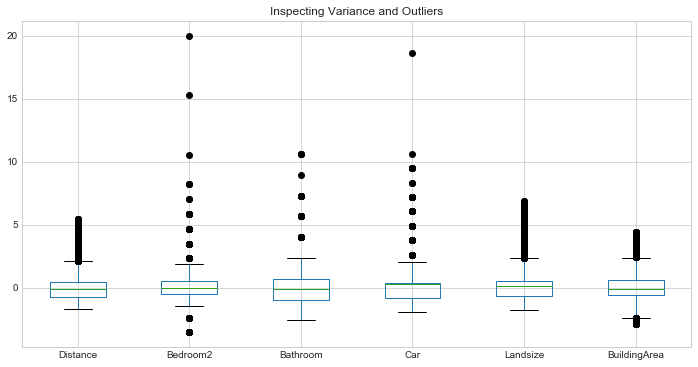

In [10]:
# Plot a boxplot to inspect variance
scaled_data.iloc[:,4:-1].boxplot(figsize=(12,6), sym='ko', grid=True)
plt.title('Inspecting Variance and Outliers')
plt.show()

There are still some outliers, especially on the 'Bedroom2' and 'Car' variables. To avoid dropping too many observations, we'll keep the data as it is.

### Creating dummy variables
Regression models require that categorical values are converted to numerical binary dummy data.

In [13]:
# Create dummies dataframe
dummies = pd.get_dummies(scaled_data.iloc[:,-4:])

In [14]:
# Concatenate scaled and dummy data
scaled_dummies = pd.concat([scaled_data.iloc[:,:10], dummies],axis=1)
scaled_dummies.head(3)

,Price,YearBuilt,Year,Rooms,Distance,Bedroom2,Bathroom,Car,Landsize,BuildingArea,...,SellerG_hockingstuart/Harcourts,SellerG_hockingstuart/Marshall,SellerG_hockingstuart/Sweeney,SellerG_hockingstuart/Village,SellerG_hockingstuart/hockingstuart,SellerG_iHomes,SellerG_iOne,SellerG_iProperty,SellerG_iSell,SellerG_iTRAK
0,1480000.0,-0.856776,-1.316898,-1.045462,-1.310818,-1.213028,-0.957132,-0.801342,-1.040062,-0.939287,...,0,0,0,0,0,0,0,0,0,0
1,1035000.0,-2.438107,-1.316898,-1.045462,-1.310818,-1.213028,-0.957132,-1.942040,-1.205510,-1.371731,...,0,0,0,0,0,0,0,0,0,0
2,1465000.0,-2.438107,0.252201,0.015338,-1.310818,-0.036443,0.694375,-1.942040,-1.284637,0.011840,...,0,0,0,0,0,0,0,0,0,0


# Predicting house values
Since this is a regression problem with more than 700 variables, the following models are used to predict house values:

- KNN Regression
- Random Forest Regression
- LASSO Regression
- Ridge Regression
- Support Vector Machine Regressor
- Gradient Boosting Regressor

### Split the data set to train and test subsets

Sklearn's train_test_split method shuffles and splits the data into a train subset (60% sample size) and a test subset (40% sample size).

In [15]:
# Shuffle and split the data into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(scaled_dummies.iloc[:,1:],
                                                    scaled_dummies.iloc[:,0],
                                                    test_size=0.4, random_state=0)

## KNN Regressor
The KNN regressor model sorts the 'K' number of most similar (or nearest) data points. Similarity is measured according to a proximity metric that can be defined in the model's parameters. The target is predicted by local [interpolation](https=//whatis.techtarget.com/definition/extrapolation-and-interpolation) of the nearest neighbors in the training set.

In [42]:
# Call the model with selected parameters
knn = KNeighborsRegressor(algorithm='kd_tree', n_neighbors=10, leaf_size=5, weights='distance',
                           metric='minkowski')

# Start the timer function to inspect the amount of time necessary to run the method
start_time = time.time()

# Cross-validate
cv = cross_val_score(knn, X_test, y_test, cv=8, n_jobs=-1)

# Stop the timer function and inspect the time taken to run the method
print("--- time elapsed %s seconds ---" % (time.time() - start_time))

# Inspect the results
print('\nAverage score:', np.mean(cv))
print('\nCross-validation scores:', cv)

--- time elapsed 26.15169906616211 seconds ---

Average score: 0.6395560492646981

Cross-validation scores: [0.65171972 0.59116695 0.63590207 0.62894111 0.68735662 0.63739141
 0.64589664 0.63807388]


#### Plot the results against the actual data to visualize the accuracy of the model

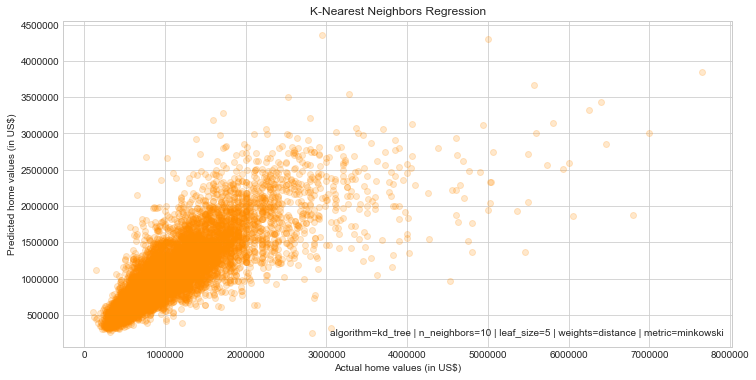

In [35]:
# Fit and predict the model; store values in a variable
y_knn_predicted = knn.fit(X_train, y_train).predict(X_test)

# Set the plot's figure size
plt.figure(figsize=(12,6))

# Generate the scatter plot and customize the label, title and legend
plt.scatter(y_test, y_knn_predicted, color='darkorange', alpha=.2, 
            label='algorithm=kd_tree | n_neighbors=10 | leaf_size=5 | weights=distance | metric=minkowski')
plt.xlabel('Actual home values (in US$)')
plt.ylabel('Predicted home values (in US$)')
plt.title('K-Nearest Neighbors Regression')
plt.legend()
plt.show()

The n_neighbors parameter defines how many similar data points to consider in the calculation, and was set to 10 (the default is 5). Increasing n_neighbors value beyond 10 will increase noise and decrease scores.

The algorithm uses the [Minkoswski Distance](http=//www.code10.info/index.php%3Foption%3Dcom_content%26view%3Darticle%26id%3D61=articleminkowski-distance%26catid%3D38=cat_coding_algorithms_data-similarity%26Itemid%3D57) scoring metric to identify the k-nearest (or most similar) neighbors. This scoring metric returns the distance along an axis on which two objects show the greatest absolute difference.

Using Minkoswki distance scores, the [k-dimensional tree](http=//pointclouds.org/documentation/tutorials/kdtree_search.php) algorithm organizes data points into the k-number of points according to their similarity.

Finally, while the default 'uniform' parameter weights all nearest points equally, the 'distance' weighting parameter gives closer points greater influence.

## Random Forest Regressor

Random Forest is a 'bagging' ensemble model consisting of multiple decision trees. The trees are generated with randomly selected samples of the data, with varied depths (e.g., a varied number of leaves and branches). Trees get a "vote" on the outcome of each observation. The predictions with most votes are returned.

In [43]:
# Call the model with the selected parameters
rfr = ensemble.RandomForestRegressor(min_samples_leaf=1, min_samples_split=2,n_estimators=200,
                                    max_features=200)

# This "if" statement makes models run in the main program to prevent infinite multi-processing loops
if __name__ == '__main__':
    multiprocessing.set_start_method('forkserver', force=True)

    # Start the timer function to inspect the amount of time necessary to run the method
    start_time = time.time()
    
    # Call the cross-validation function
    cv = cross_val_score(rfr, X_test, y_test, cv=8, n_jobs=-1)
    
    # Stop the timer function and inspect the time taken to run the method
    print("--- time elapsed %s seconds ---" % (time.time() - start_time))

# Inspect the results
print('\nAverage score:', np.mean(cv))
print('\nCross-validation scores:', cv)

--- time elapsed 34.98653864860535 seconds ---

Average score: 0.7347349095160602

Cross-validation scores: [0.74184429 0.71240637 0.74295546 0.72884719 0.74923126 0.71378174
 0.73975568 0.74905728]


#### Plot the results against the actual data to visualize the accuracy of the model

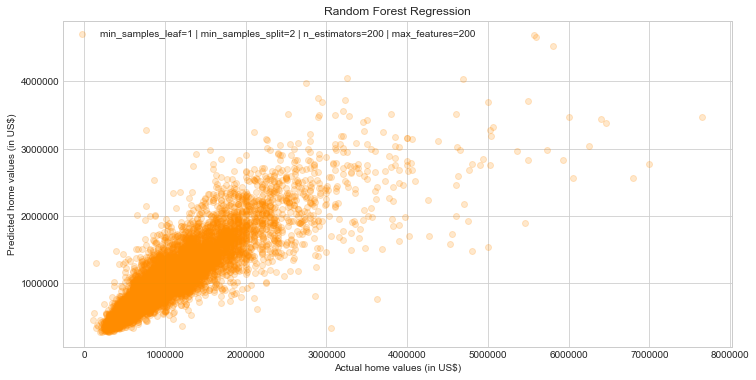

In [39]:
# Fit and predict the model; store values in a variable
y_rfr_predicted = rfr.fit(X_train, y_train).predict(X_test)

# Generate the scatter plot and customize the label, title and legend
plt.figure(figsize=(12,6))
plt.scatter(y_test, y_rfr_predicted, color='darkorange', alpha=.2, 
            label='min_samples_leaf=1 | min_samples_split=2 | n_estimators=200 | max_features=200')
plt.xlabel('Actual home values (in US$)')
plt.ylabel('Predicted home values (in US$)')
plt.title('Random Forest Regression')
plt.legend()
plt.show()

Our data set has +600 features, so the trees benefit from being large and complex. Therefore, the best results were obtained by keeping 'min_samples_leaf' and 'min_samples_split' at their smallest values to allow more leaves at each branch. Also, 'max_features' was set at 200 so that trees can take a good number of features into consideration. Finally, 'n_estimators' was be set to 200, so that the model can generate sufficient trees to cover a good number of feature combinations.

## Lasso Regression

Our feature space is +600, so we’ll use Lasso as our regression model. Lasso uses the coordinate descent algorithm to iteratively fit the model with all features minus one. Features that do not contribute to scoring are excluded (by setting their coefficients to zero), simplifying the model and increasing efficiency.

With max_iter=1000, the model is set to run up to 1000 times, **or** until the error cost function reaches the minimum tolerance of 0.0001 points on each iteration.

In [44]:
# Declare the model with the selected parameters
lasso = linear_model.Lasso(alpha=60, fit_intercept=True, max_iter=1000, tol=0.0001, warm_start=False,
              selection='cyclic')

# Fit the model with test data
lasso.fit(X_test, y_test)

# Count the number of zero coefficients
print('Number of coefficients set to zero:', np.count_nonzero(lasso.coef_==0))

# This "if" statement makes models run in the main program to prevent infinite multi-processing loops
if __name__ == '__main__':
    multiprocessing.set_start_method('forkserver', force=True)
    
    # Start the timer function to inspect the amount of time necessary to run the method
    start_time = time.time()

    # Call the cross-validation function
    cv = cross_val_score(lasso, X_test, y_test, cv=8, n_jobs=-1)
    
    # Stop the timer function and inspect the time taken to run the method
    print("\n--- time elapsed %s seconds ---" % (time.time() - start_time))

# Inspect the results
print('\nAverage score:', np.mean(cv))
print('\nCross-validation scores:', cv)

Number of coefficients set to zero: 336

--- time elapsed 12.333617210388184 seconds ---

Average score: 0.6770448012680093

Cross-validation scores: [0.66228381 0.65426382 0.67816772 0.69936584 0.68402004 0.6767094
 0.67338259 0.68816519]


#### Plot the results against the actual data to visualize the accuracy of the model

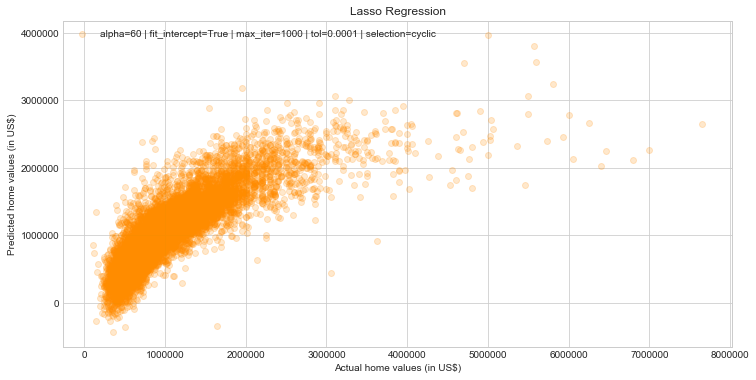

In [34]:
# Fit and predict the model; store values in a variable
y_lasso_predicted = lasso.fit(X_train, y_train).predict(X_test)

# Generate the scatter plot and customize the label, title and legend
plt.figure(figsize=(12,6))
plt.scatter(y_test, y_lasso_predicted, color='darkorange', alpha=.2, 
            label='alpha=60 | fit_intercept=True | max_iter=1000 | tol=0.0001 | selection=cyclic')
plt.xlabel('Actual home values (in US$)')
plt.ylabel('Predicted home values (in US$)')
plt.title('Lasso Regression')
plt.legend()
plt.show()

Lasso's cost function has a regularization parameter (called L1 parameter) that penalizes the sum of the absolute values of the coefficients, multiplied by the alpha parameter. The higher the alpha, the greater the number of coeffeicients "penalized" to zero. Setting alpha to zero makes Lasso act as an Ordinary Least Squares regression.

Sklearn's default alpha value is 1. With alpha set to 60, the model gained only less than 0.01 score points (compared with the default alpha=1 value). Although the change in score was negligible, Lasso dropped 336 features from the model, reducing complexity by more than 50% and reducing processing time.

### Support Vector Machine Regressor
The Support Vector Machine Regressor (SVR) is an effective machine learning method for high dimensional spaces, including when the number of variables (or dimensions) exceeds the number of samples.

In SVR, the data is plotted as points in an n-dimensional space (with 'n' being the number of variables + the cost function).  The term 'support vectors' refers to the vector coordinates of each data point. SVR creates a best fit prediction that consists of a hyperplane with an n-minus-one-dimension, that minimizes the sum of the distances between the prediction and the data points. 

In [16]:
# Call the model with selected parameters
svr = SVR(kernel='linear', C=50000, cache_size=1000, epsilon=1)

# This "if" statement makes models run in the main program to prevent infinite multi-processing loops
if __name__ == '__main__':
    multiprocessing.set_start_method('forkserver', force=True)
    
    # Start the timer function to inspect the amount of time necessary to run the method
    start_time = time.time()

    # Call the cross-validation function
    cross_val_score(svr, X_test, y_test, cv=8, n_jobs=-1)
    
    # Stop the timer function and inspect the time taken to run the method
    print("\n--- time elapsed %s seconds ---" % (time.time() - start_time))

[0.60053801 0.59975808 0.64778297 0.6493428  0.63242255 0.63149005
 0.67891974 0.66237988]

--- time elapsed 176.97621393203735 seconds ---


#### Plot the results against the actual data to visualize the accuracy of the model

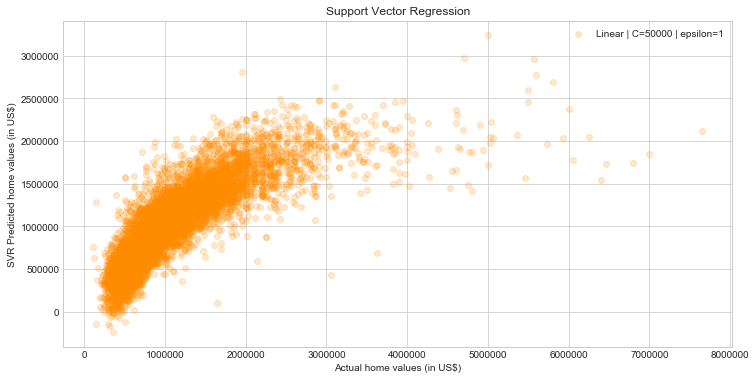

In [30]:
# Fit and predict the model; store values in a variable
y_svr_predicted = svr.fit(X_train, y_train).predict(X_test)

# Generate the scatter plot and customize the label, title and legend
plt.figure(figsize=(12,6))
plt.scatter(y_test, y_svr_predicted, color='darkorange', alpha=.2, label='Linear | C=50000 | epsilon=1')
plt.xlabel('Actual home values (in US$)')
plt.ylabel('Predicted home values (in US$)')
plt.title('Support Vector Regression')
plt.legend()
plt.show()

To minimize the cumulative distance of points on the wrong side of the margin, SVR has an 'epsilon' parameter to determine the size of a margin around the prediction; and a 'C' parameter that sets the penalty for being outside of that margin. The score is computed as the R-squared value, which is a measure of how close the data are to the fitted regression line (R-squared values range from zero to one, where one means that values are closer to the data).

Recall that all continuous features were scaled, **except house values**. Their values range from $85,000 to $11,200,000. For this reason, SVR had the best results when the C parameter was set to 50,000.

### Gradient Boosting
The gradient boosting classifier used here is an ensemble of "weak" decision trees that are run in sequence. The residuals of each decision tree is used as the outcome to be predicted by the subsequent tree. Predictions are given by adding the values of all decision trees.

In [45]:
# Call the model with selected parameters
gbr = ensemble.GradientBoostingRegressor(max_depth=7, n_estimators=300,
                                          warm_start=True)

# This "if" statement makes models run in the main program to prevent infinite multi-processing loops
if __name__ == '__main__':
    multiprocessing.set_start_method('forkserver', force=True)

    cv = cross_val_score(gbr, X_test, y_test, cv=8, n_jobs=-1)
    
    # Stop the timer function and inspect the time taken to run the method
    print("--- time elapsed %s seconds ---" % (time.time() - start_time))

# Inspect the results
print('\nAverage score:', np.mean(cv))
print('\nCross-validation scores:', cv)

--- time elapsed 27821.649317979813 seconds ---

Average score: 0.7498345158317112

Cross-validation scores: [0.74445752 0.7193745  0.76167275 0.74410119 0.7523077  0.76022733
 0.74479527 0.77173985]


#### Plot the results against the actual data to visualize the accuracy of the model

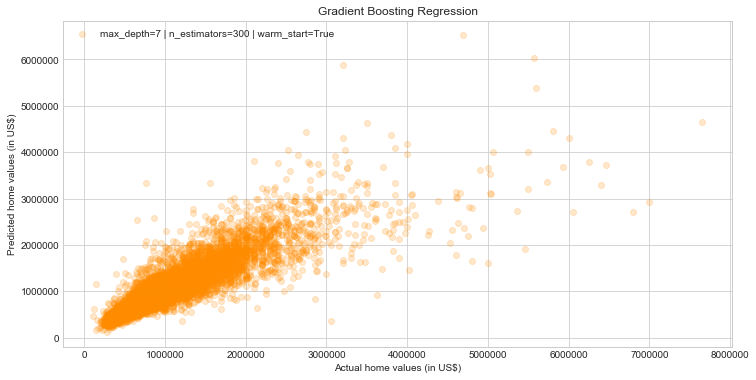

In [44]:
# Fit and predict the model; store values in a variable
y_gbr_predicted = gbr.fit(X_train, y_train).predict(X_test)

# Generate the scatter plot and customize the label, title and legend
plt.figure(figsize=(12,6))
plt.scatter(y_test, y_gbr_predicted, color='darkorange', alpha=.2, 
            label='max_depth=7 | n_estimators=300 | warm_start=True')
plt.xlabel('Actual home values (in US$)')
plt.ylabel('Predicted home values (in US$)')
plt.title('Gradient Boosting Regression')
plt.legend()
plt.show()

Once again, parameter values were influenced by the fact that we have +700 features. Although Gradient Boosting benefits from generating multiple "weak" decision trees, the model performs better with max_depth=7 instead of the default tree depth of 3. Also, the number of estimators was set to 300, to let the model iterate through trees with all possible variable combinations.

## Inspecting variable correlation
We'll look at how each variable correlates with home prices to understand what creates value in a house.

In [23]:
# Generate the correlation matrix
corr_matrix = scaled_data.corr()

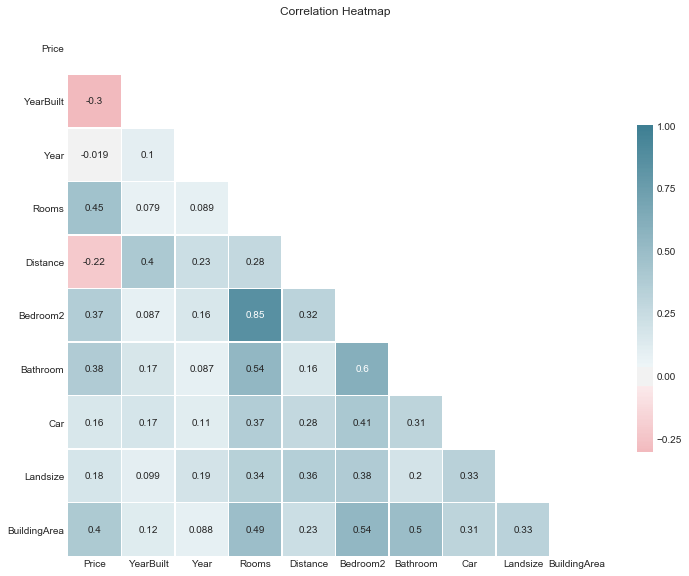

In [24]:
# Create a correlation heatmap
# Generate a mask for the upper triangle
mask = np.zeros_like(corr_matrix,dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 220, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix,
            mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True)
plt.title('Correlation Heatmap')
plt.show()

The above correlation heatmap visualizes Pearson's R correlation coefficient, which is a measure the strength of the relationship between each pair of variables. The coefficient ranges from positive one (indicating a high positive correlation) to negative one (indicating a high negative correlation). Zero indicates that variables are not correlated. 

Not surprisingly, home prices are positively correlated with their number of rooms (R=0.45), bathrooms (R=0.38), and building area (R=0.4). This means that homes with more rooms/bathrooms/built area have higher prices. On the other hand, the year built and distance variables are negatively correlated to prices (R=-0.3 and -0.22 respectively), as one would expect.

## Conclusion

All models performed fairly well for houses with values ranging from $85,000 to $200,000. The models tended to lose accuracy above those values, with predictions being skewed to lower than actual values. This is likely explained by the presence of a large number of outliers on most variables.

Likewise, the two models with best performance were the decision trees-based Random Forest and Gradient Boosting. This is because these models are less affected by outliers than regression-based models.